# 파트 10
----
각종 탐구적 분석 과정에서 나온 결과물들이 들어있다. 단순 가격의 평균값, 중앙값과 다른 변수들과의 비선형성 관계를 확인 할 수 있다. 또한 가격변화율에 대한 회귀분석을 해 보았으나, 유의미한 예측수치가 나오지 않는 것을 확일 할 수 있다.

In [49]:
%matplotlib inline
from __future__ import division
from __future__ import print_function
import sklearn.preprocessing
import sklearn.feature_selection

In [139]:
# setting the folder path and read in data
path = 'raw_data\\'
df_original = pd.read_csv(path + '07_pop_estate_year.csv', encoding='utf-8')

In [140]:
# changing the column order
df_columns = [u'year', u'area_code', u'trade_vol',
              u'mov_vol', u'head_ratio', u'head_male_ratio', u'head_age', u'multi_ratio', u'ppl_per_house',
              u'mov_ppl_vol', u'mov_male_ratio', u'pop_change_ratio', u'built',
              u'r_1', u'r_2', u'r_3', u'r_5', u'r_4', u'r_6', u'r_9',
              u'ppa_median', u'ppa_mean', u'ppa_median_log', u'ppa_change_pre', u'ppa_change_post']

df = df_original[df_columns]

In [141]:
years = range(2006, 2015)

In [142]:
df.head()

,year,area_code,trade_vol,mov_vol,head_ratio,head_male_ratio,head_age,multi_ratio,ppl_per_house,mov_ppl_vol,...,r_3,r_5,r_4,r_6,r_9,ppa_median,ppa_mean,ppa_median_log,ppa_change_pre,ppa_change_post
0,2006,11110,726.0,53130.0,0.773970,0.645874,40.901875,0.342594,1.695200,90066.0,...,-0.004197,0.002033,0.009825,-0.000960,-0.007642,339.575046,369.636029,5.827695,1.196688,NaN
1,2006,11140,1010.0,42733.0,0.771160,0.648935,41.031013,0.330003,1.656050,70768.0,...,-0.017200,0.001287,0.003908,-0.000936,-0.006201,462.128795,457.123602,6.135844,1.045736,NaN
2,2006,11170,2415.0,83396.0,0.791513,0.630687,40.849627,0.349069,1.704194,142123.0,...,0.003537,-0.000096,-0.000288,-0.001487,-0.019018,564.971751,602.588603,6.336776,1.198596,NaN
3,2006,11200,4204.0,102922.0,0.768776,0.671212,39.905427,0.374400,1.777152,182908.0,...,-0.001059,0.000933,0.002857,-0.000641,-0.010270,466.329966,478.887059,6.144893,1.161458,NaN
4,2006,11215,2658.0,125386.0,0.794283,0.649972,38.791690,0.380864,1.801972,225942.0,...,0.035881,0.001459,0.005559,-0.000949,-0.007082,501.504514,512.469919,6.217613,1.179194,NaN


In [143]:
df = df.set_index('area_code')

In [144]:
# just a helper list
ppa_columns = ['ppa_mean', 'ppa_median', 'ppa_median_log', 'ppa_change_pre', 'ppa_change_post']

In [161]:
# custom class containing a fitted linear regression model,
# parameters, targets, and area codes for easy access
class Custom_df:
    def __init__(self, df, target='ppa_median'):
        # create a scaler for a given dataframe
        self.dfX = df.drop(ppa_columns, axis=1)
        self.dfy = df[ppa_columns]
        
        self.df_scaler = Scaler(self.dfX, self.dfy)
        
        # create a normalized copy
        self.df_normal = pd.DataFrame(self.df_scaler.X.transform(self.dfX), index=self.dfX.index, columns=self.dfX.columns)
        
        # patching things up
        if 0 in self.df_normal.index:
            self.df_normal = self.df_normal.reset_index(0)
        
        self.dfX, self.dfy, self.result = optimize_fit(self.df_normal, self.dfy, target)
        
        self.area_codes = df.index.unique()

In [162]:
# custom scaler object for easier use
class Scaler:
    def __init__(self, dfX, dfy):
        self.X = sk.preprocessing.StandardScaler()
        self.ppa_mean = sk.preprocessing.StandardScaler()
        self.ppa_median = sk.preprocessing.StandardScaler()
        self.ppa_median_log = sk.preprocessing.StandardScaler()
        
        self.X.fit(dfX)
        self.ppa_mean.fit(dfy[['ppa_mean']])
        self.ppa_median.fit(dfy[['ppa_median']])
        self.ppa_median_log.fit(dfy[['ppa_median_log']])

In [163]:
# this is an automated linear regression method
# first throws out variables with high F probability (greater than 0.01)
# then throws out variables that aren't statistically significant
def optimize_fit(df_normal, dfy, target):
    dfX = sm.add_constant(df_normal)
#   dfy = pd.DataFrame(df_normal, columns=ppa_columns)
    
    F, F_p = sk.feature_selection.f_regression(dfX, dfy[target])
    f_reg = pd.DataFrame(F_p, index=dfX.columns, columns=['F_p'])
    
    dfX = dfX.drop(f_reg.loc[f_reg.F_p > 0.01].index, axis=1)
    
    # fit model
    model = sm.OLS(dfy[target], dfX)
    result = model.fit()
    
    conf_int = result.conf_int()
    
    dfX = dfX.drop(conf_int[conf_int.product(axis=1) < 0].index, axis=1)
    
    model = sm.OLS(dfy[target], dfX)
    result = model.fit()
    
    return dfX, dfy, result

In [217]:
# we try a regression analysis on mean prices
df_custom = Custom_df(df, 'ppa_mean')
print(df_custom.result.summary())

                            OLS Regression Results                            
Dep. Variable:               ppa_mean   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     288.3
Date:                Sat, 08 Jul 2017   Prob (F-statistic):               0.00
Time:                        16:12:39   Log-Likelihood:                -13677.
No. Observations:                2274   AIC:                         2.738e+04
Df Residuals:                    2260   BIC:                         2.746e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const             212.6154      2.083    1

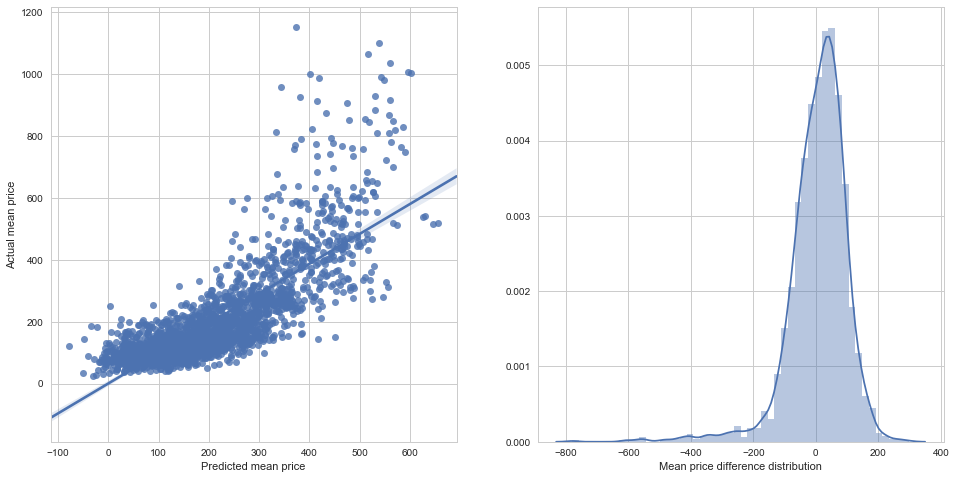

In [218]:
# plot predicted price vs actual price
# restuls aren't quite satisfactory
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.regplot(df_custom.result.predict(df_custom.dfX), df_custom.dfy.ppa_median)
plt.xlabel('Predicted mean price')
plt.ylabel('Actual mean price')

plt.subplot(1, 2, 2)
sns.distplot(df_custom.result.predict(df_custom.dfX) - df_custom.dfy.ppa_median)
plt.xlabel('Mean price difference distribution')

In [219]:
# we try a different approach and do the same on median prices
df_custom = Custom_df(df, 'ppa_median')
print(df_custom.result.summary())

                            OLS Regression Results                            
Dep. Variable:             ppa_median   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     292.2
Date:                Sat, 08 Jul 2017   Prob (F-statistic):               0.00
Time:                        16:12:59   Log-Likelihood:                -13585.
No. Observations:                2274   AIC:                         2.720e+04
Df Residuals:                    2260   BIC:                         2.728e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const             205.9041      2.001    1

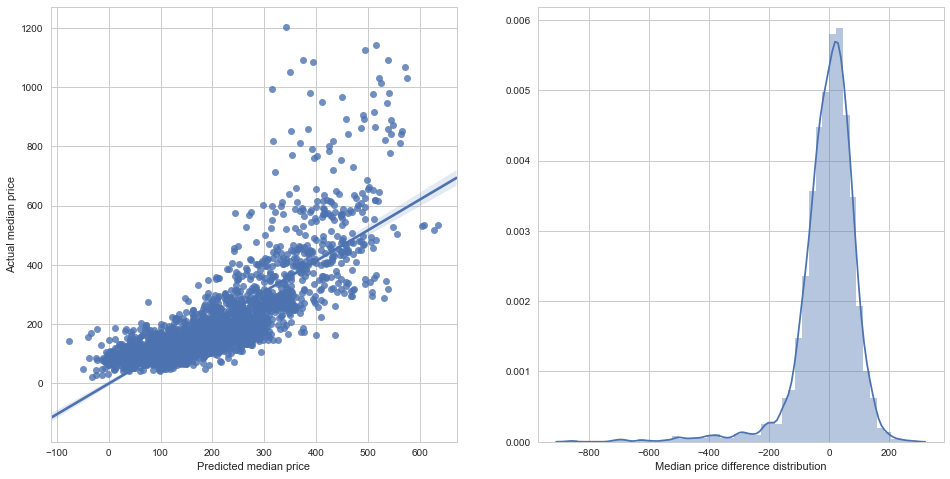

In [220]:
# plot predicted price vs actual price
# restuls aren't quite satisfactory
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.regplot(df_custom.result.predict(df_custom.dfX), df_custom.dfy.ppa_mean)
plt.xlabel('Predicted median price')
plt.ylabel('Actual median price')

plt.subplot(1, 2, 2)
sns.distplot(df_custom.result.predict(df_custom.dfX) - df_custom.dfy.ppa_mean)
plt.xlabel('Median price difference distribution')

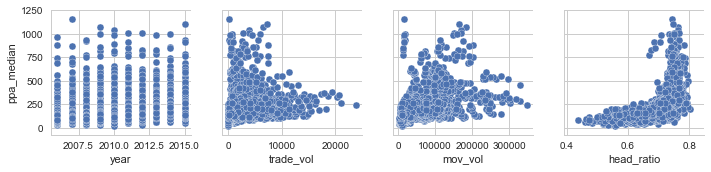

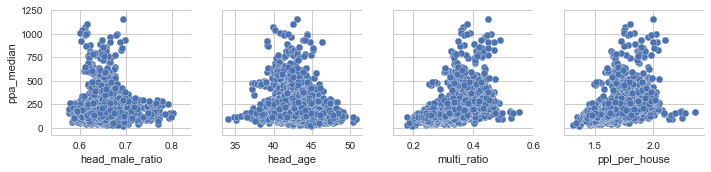

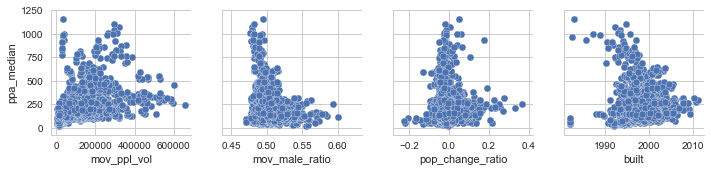

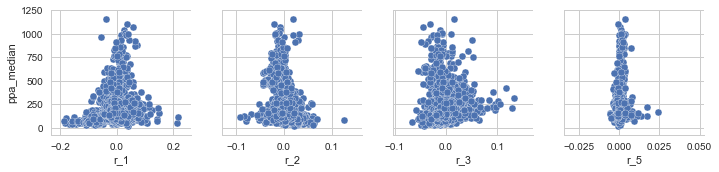

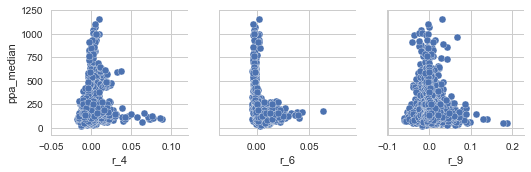

In [226]:
# some plotting to diagnose the problem
# there doesn't seem to be much of a linear relation between
# median prices and other parameters
x_vars = [u'year', u'trade_vol',
          u'mov_vol', u'head_ratio', u'head_male_ratio', u'head_age', u'multi_ratio', u'ppl_per_house',
          u'mov_ppl_vol', u'mov_male_ratio', u'pop_change_ratio', u'built',
          u'r_1', u'r_2', u'r_3', u'r_5', u'r_4', u'r_6', u'r_9',]

n = 4
m = len(x_vars) // n
for i in range(n + 1):
    sns.pairplot(df.drop(['ppa_change_pre', 'ppa_change_post'], axis=1),
                 x_vars=x_vars[m * i:m * (i + 1)],
                 y_vars=['ppa_median'])

In [238]:
# we try a different approach and do the same on median prices
df_custom = Custom_df(df.loc[~df.ppa_change_pre.isnull()], 'ppa_change_pre')
print(df_custom.result.summary())

                            OLS Regression Results                            
Dep. Variable:         ppa_change_pre   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     31.99
Date:                Sat, 08 Jul 2017   Prob (F-statistic):           2.09e-14
Time:                        16:23:13   Log-Likelihood:                 442.39
No. Observations:                2044   AIC:                            -878.8
Df Residuals:                    2041   BIC:                            -861.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.0828      0.004    251.012      0.0

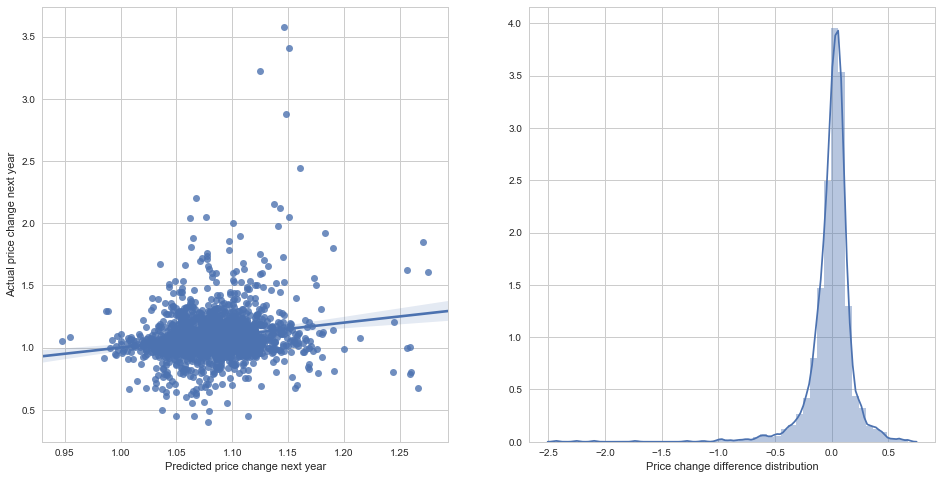

In [239]:
# plot predicted price vs actual price
# restuls are pretty bad
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.regplot(df_custom.result.predict(df_custom.dfX), df_custom.dfy.ppa_change_pre)
plt.xlabel('Predicted price change next year')
plt.ylabel('Actual price change next year')

plt.subplot(1, 2, 2)
sns.distplot(df_custom.result.predict(df_custom.dfX) - df_custom.dfy.ppa_change_pre)
plt.xlabel('Price change difference distribution')

In [240]:
# we try a different approach and do the same on median prices
df_custom = Custom_df(df.loc[~df.ppa_change_post.isnull()], 'ppa_change_post')
print(df_custom.result.summary())

                            OLS Regression Results                            
Dep. Variable:        ppa_change_post   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     38.93
Date:                Sat, 08 Jul 2017   Prob (F-statistic):           2.56e-17
Time:                        16:23:14   Log-Likelihood:                 449.11
No. Observations:                2044   AIC:                            -892.2
Df Residuals:                    2041   BIC:                            -875.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.0828      0.004    251.838      0.0

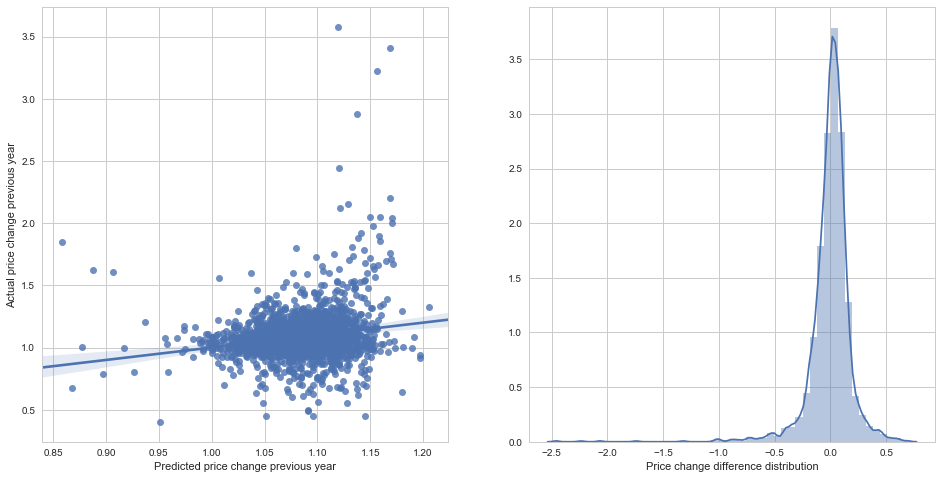

In [241]:
# plot predicted price vs actual price
# restuls are just as bad
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.regplot(df_custom.result.predict(df_custom.dfX), df_custom.dfy.ppa_change_post)
plt.xlabel('Predicted price change previous year')
plt.ylabel('Actual price change previous year')

plt.subplot(1, 2, 2)
sns.distplot(df_custom.result.predict(df_custom.dfX) - df_custom.dfy.ppa_change_post)
plt.xlabel('Price change difference distribution')